* This notebook was part of UpGrad Kagglethon, initiative to help their cohort getting started with Kaggle competitions. To be compliant with rules, I am sharing everything that was discussed during those sessions. 

** Why do Kaggle**

* Learning new things
* strenghtnen intuition for ml algorithms and techniques
* like competing with fellow kagglers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

** Problem statement **
https://www.kaggle.com/c/santander-customer-transaction-prediction



In [2]:
# Lets go ahead  and have a look at data
DATA_PATH = "../input/santander-customer-transaction-prediction/"  

train = pd.read_csv(str(Path(DATA_PATH) / "train.csv"))
test = pd.read_csv(str(Path(DATA_PATH) / "test.csv"))

print("Train and test shapes", train.shape, test.shape)

Train and test shapes (200000, 202) (200000, 201)


In [3]:
train.columns, test.columns

(Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
        'var_5', 'var_6', 'var_7',
        ...
        'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
        'var_196', 'var_197', 'var_198', 'var_199'],
       dtype='object', length=202),
 Index(['ID_code', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
        'var_6', 'var_7', 'var_8',
        ...
        'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
        'var_196', 'var_197', 'var_198', 'var_199'],
       dtype='object', length=201))

In [4]:
train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [5]:
# https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
def woe(X, y):
    tmp = pd.DataFrame()
    tmp["variable"] = X
    tmp["target"] = y
    var_counts = tmp.groupby("variable")["target"].count()
    var_events = tmp.groupby("variable")["target"].sum()
    var_nonevents = var_counts - var_events
    tmp["var_counts"] = tmp.variable.map(var_counts)
    tmp["var_events"] = tmp.variable.map(var_events)
    tmp["var_nonevents"] = tmp.variable.map(var_nonevents)
    events = sum(tmp["target"] == 1)
    nonevents = sum(tmp["target"] == 0)
    tmp["woe"] = np.log(((tmp["var_nonevents"])/nonevents)/((tmp["var_events"])/events))
    tmp["woe"] = tmp["woe"].replace(np.inf, 0).replace(-np.inf, 0)
    tmp["iv"] = (tmp["var_nonevents"]/nonevents - tmp["var_events"]/events) * tmp["woe"]
    iv = tmp.groupby("variable")["iv"].last().sum()
    return tmp["woe"], tmp["iv"], iv

In [6]:
iv_values = []
feats = ["var_{}".format(i) for i in range(200)]
y = train["target"]
for f in feats:
    X = pd.qcut(train[f], 10, duplicates='drop')
    _, _, iv = woe(X, y)
    iv_values.append(iv)
    
iv_inds = np.argsort(iv_values)[::-1][:50]
iv_values = np.array(iv_values)[iv_inds]
feats = np.array(feats)[iv_inds]


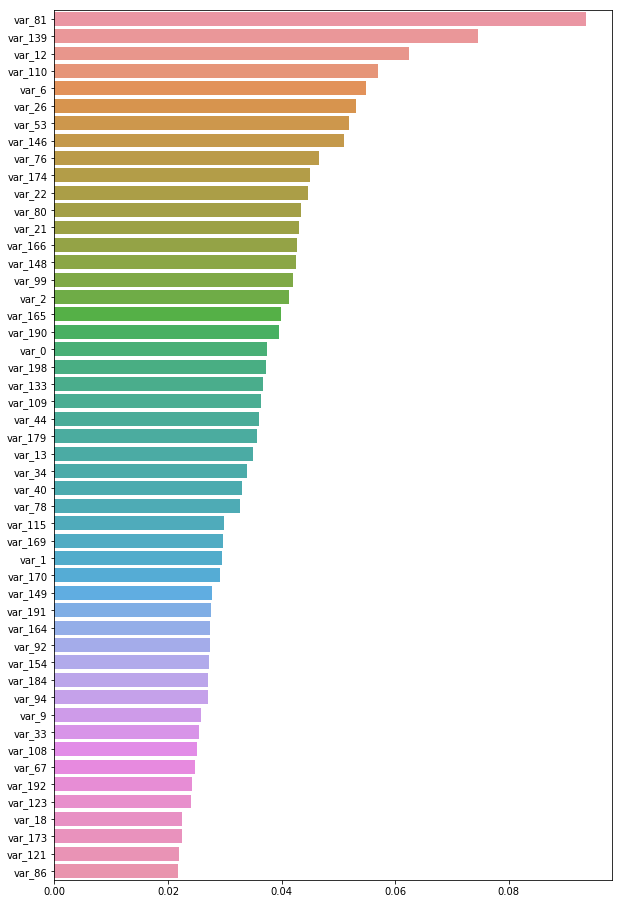

In [7]:
plt.figure(figsize=(10, 16))
sns.barplot(y=feats, x=iv_values, orient='h')
plt.show()

## EDA

### Pointers
* Check out existing kernels
https://www.kaggle.com/gpreda/santander-eda-and-prediction
https://www.kaggle.com/artgor/santander-eda-fe-fs-and-models
https://www.kaggle.com/mjbahmani/santander-ml-explainability

* Check distributions
* Compare train and test distributions
* Identify important features (Most of the times feature engineering is going to be around features with high predictive power)
* Attach a logic to why featurea are important ( Note: data is anonymised  here so hard to do this)
* Check previous solutions to similar problems


### Observations
* Data normalization and imputation
* Weak corelations between features and target
* IV values ??
* Most variables have distribution close to normal
* Almost no corelation between differnt variable - What does it mean ??
* No NA values (already imputed??)
* Some features seem to have been clipped at one end
* Spikes in distributions (imputed values??)
* less unique 

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [9]:
feats = ["var_{}".format(i) for i in range(200)]
X = train[feats]
X_test = test[feats]
y = train["target"]

cvlist = list(StratifiedKFold(5, random_state=12345786).split(X, y))
scaler = StandardScaler()

X_sc = scaler.fit_transform(X)
X_test_sc = scaler.fit_transform(X_test)

lr = LogisticRegression()
y_preds_lr = cross_val_predict(lr, X_sc, y, cv=cvlist, method="predict_proba")[:, 1]

lr.fit(X_sc, y)
y_test_preds_lr = lr.predict_proba(X_test_sc)[:, 1] 
roc_auc_score(y, y_preds_lr)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

0.8594252422559592

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


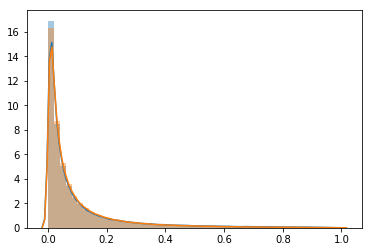

In [10]:
sns.distplot(y_preds_lr)
sns.distplot(y_test_preds_lr)
plt.show()

### Method -1 : train on full and predict on test
 - rule  - scale boosting rounds by train data ratio to data during validation - 1500 

In [11]:
import lightgbm as lgb
#model = lgb.LGBMClassifier(n_estimators=2000, learning_rate=0.1, num_leaves=2, subsample=0.4, colsample_bytree=0.4)

#y_preds_lgb = np.zeros((len(y)))
#for i, (tr_idx, val_idx) in enumerate(cvlist):
#    X_dev, y_dev = X.iloc[tr_idx], y.iloc[tr_idx]
#    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
#    model.fit(X_dev, y_dev, eval_set=[(X_val, y_val)], eval_metric="auc", verbose=50, early_stopping_rounds=200)
#    val_preds = model.predict_proba(X_val)[:, 1]
#    y_preds_lgb[val_idx] = val_preds
#    print("Score for fold {} is {}".format(i, roc_auc_score(y_val, val_preds)))
    
#print("Overall Score for oof predictions ", roc_auc_score(y, y_preds_lgb))

In [12]:
#model = lgb.LGBMClassifier(n_estimators=1500, learning_rate=0.1, num_leaves=8, subsample=0.6, colsample_bytree=0.6)
#model.fit(X, y)
#y_test_preds_lgb = model.predict_proba(X_test)[:, 1]


In [13]:
#sns.distplot(y_preds)
#sns.distplot(y_test_preds_lgb)

### Method 2 - use validation fold models to predict on test set


In [14]:
from scipy.stats import gmean

In [15]:
np.mean([0.9, 0.9, 0.9, 0.98, 0.9])

0.916

In [16]:
gmean([0.9, 0.9, 0.9, 0.98, 0.9])

0.9154596830713997

In [17]:
!pip install -U lightgbm

Requirement already up-to-date: lightgbm in /opt/conda/lib/python3.6/site-packages (2.2.3)


In [18]:
import lightgbm as lgb
model = lgb.LGBMClassifier(boosting_type='gbdt', n_estimators=200000, learning_rate=0.02, num_leaves=2, subsample=0.4, colsample_bytree=0.4, seed=1)

y_preds_lgb = np.zeros((len(y)))
test_preds_allfolds = []
for i, (tr_idx, val_idx) in enumerate(cvlist):
    X_dev, y_dev = X.iloc[tr_idx], y.iloc[tr_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    model.fit(X_dev, y_dev, eval_set=[(X_val, y_val)], eval_metric="auc", verbose=5000, early_stopping_rounds=1000)
    val_preds = model.predict_proba(X_val)[:, 1]
    test_preds = model.predict_proba(X_test)[:, 1]
    test_preds_allfolds.append(test_preds)
    y_preds_lgb[val_idx] = val_preds
    print("Score for fold {} is {}".format(i, roc_auc_score(y_val, val_preds)))
    # break
print("Overall Score for oof predictions ", roc_auc_score(y, y_preds_lgb))

Training until validation scores don't improve for 1000 rounds.
[5000]	valid_0's binary_logloss: 0.234361	valid_0's auc: 0.877086
[10000]	valid_0's binary_logloss: 0.21698	valid_0's auc: 0.889926
[15000]	valid_0's binary_logloss: 0.209472	valid_0's auc: 0.894873
[20000]	valid_0's binary_logloss: 0.205809	valid_0's auc: 0.897024
[25000]	valid_0's binary_logloss: 0.2039	valid_0's auc: 0.898052
[30000]	valid_0's binary_logloss: 0.202909	valid_0's auc: 0.898527
[35000]	valid_0's binary_logloss: 0.202374	valid_0's auc: 0.898724
Early stopping, best iteration is:
[37315]	valid_0's binary_logloss: 0.202236	valid_0's auc: 0.898743
Score for fold 0 is 0.8987431730483515
Training until validation scores don't improve for 1000 rounds.
[5000]	valid_0's binary_logloss: 0.235367	valid_0's auc: 0.876533
[10000]	valid_0's binary_logloss: 0.218516	valid_0's auc: 0.888865
[15000]	valid_0's binary_logloss: 0.211578	valid_0's auc: 0.892904
[20000]	valid_0's binary_logloss: 0.208263	valid_0's auc: 0.894495

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


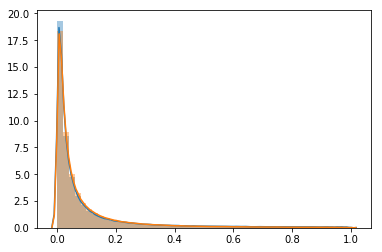

In [19]:
y_test_preds_lgb = gmean(test_preds_allfolds, 0)
sns.distplot(y_preds_lgb)
sns.distplot(y_test_preds_lgb)

In [20]:
sub = test[["ID_code"]]
sub["target"] = y_test_preds_lgb
sub.to_csv("submission_lgbm2_v1.csv", index=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Modelling

Pointers:
*  Validation strategy -- Random KFold, holdout or temporal split ??
* What to trust validation score or LB socre?? trust score from more data; if test data is more we should treat LB as additional fold
* Hyperparamter tuning -- Combination of manual tuning and bayesian optimization libraries like `hyperopt` and `scikit-optimize`. Initial tuninng on single fold and then move to 5 folds.
* Always check validation and test set prediction distributions
* ** Read forums and participate in discussions **

Disussions:
* Sometimes using geometric mean of probabilities is better than using simple mean
* When metric is ROC_AUC, even rank average can be used
* Blending -- blend of your solution and public solution can be used to improve LB score. But, better approach is to understand what is working for other people and integrate in your models.


In [21]:
weighted_preds = y_preds_lr* 0.05 + y_preds_lgb * 0.95
weighted_test_preds = y_test_preds_lr* 0.05 + y_test_preds_lgb * 0.95
roc_auc_score(y, weighted_preds)

0.8992331990761472

In [22]:
public_sub = pd.read_csv("../input/santander-lgb-new-features-rank-mean-10-folds/submission_LGBM.csv")
public_sub.head()

,ID_code,target
0,test_0,153856.4
1,test_1,177532.8
2,test_2,172858.6
3,test_3,174175.7
4,test_4,114963.5


In [23]:
sub["target"] = weighted_test_preds

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
sub["target"] = 0.2*sub["target"].rank() + 0.8*public_sub["target"]
sub.to_csv("submission_blend.csv", index=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
import keras
from keras.layers import (Flatten, Conv1D, Conv2D, Input, Dense, Dropout, BatchNormalization,
                          concatenate, GaussianNoise, Reshape, TimeDistributed, LeakyReLU, PReLU, Embedding)
from keras.models import Model, load_model, save_model
from keras.optimizers import SGD, Adam
from sklearn.base import BaseEstimator, ClassifierMixin
from pathlib import Path
from keras.callbacks import Callback

class ROC_AUC(Callback):
    def __init__(self, validation_data):
        self.X_val, self.y_val = validation_data
    
    def on_epoch_end(self, epoch, logs={}):
        print("ROC AUC for this fold, is ", roc_auc_score(self.y_val, self.model.predict(X_val)))
        
class NNv1(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 inp_shape=200,
                 gaussian_noise=0.01,
                 dense1_dim=32,
                 dense2_dim=32,
                 dense1_kwargs=None,
                 dense2_kwargs=None,
                 classifier_kwargs=None,
                 optimizer=SGD,
                 opt_kwargs=None,
                 ):
        self.inp_shape = inp_shape
        self.gaussian_noise = gaussian_noise
        self.dense1_dim = dense1_dim
        self.dense2_dim = dense2_dim
        self.dense1_kwargs = dense1_kwargs
        self.dense2_kwargs = dense2_kwargs
        self.classifier_kwargs = classifier_kwargs
        self.optimizer = optimizer
        self.opt_kwargs = opt_kwargs
        self._default_initiaization()

    def _default_initiaization(self):
        if self.dense1_kwargs is None:
            self.dense1_kwargs = {"kernel_initializer": "glorot_uniform"}
        if self.dense2_kwargs is None:
            self.dense2_kwargs = {"kernel_initializer": "he_uniform"}
        if self.classifier_kwargs is None:
            self.classifier_kwargs = {"kernel_initializer": "he_uniform"}
        if self.opt_kwargs is None:
            self.opt_kwargs = {}

    def _build_model(self):
        inp = Input(shape=(self.inp_shape,))
        # x = GaussianNoise(self.gaussian_noise)(inp)
        x = Reshape((self.inp_shape, 1))(inp)
        d1 = Dense(self.dense1_dim, activation='tanh',)(x)
        #d1 = TimeDistributed(Dropout(0.2))(d1)
        d2 = Dense(self.dense1_dim, activation='relu',)(x)
        #d2 = PReLU()(d2)
        #d2 = TimeDistributed(Dropout(0.2))(d2)
        x = concatenate([d1, d2])
        x = Flatten()(x)
        out = Dense(1, activation='sigmoid', **self.classifier_kwargs)(x)

        model = Model(inputs=inp, outputs=out)
        opt = self.optimizer(**self.opt_kwargs)
        model.compile(loss='binary_crossentropy', optimizer=opt)
        return model

    def fit(self, X, y, *args, **kwargs):
        self.model = self._build_model()
        print(self.model.summary())
        self.model.fit(X, y, *args, **kwargs)
        return self

    def predict(self, X, y=None, weight_path=None, **kwargs):
        if self.model:
            if weight_path is not None:
                self.model.load_weights(weight_path)
            y_hat = self.model.predict(X, **kwargs)
        else:
            raise ValueError("Model not fit yet")
        return y_hat


Using TensorFlow backend.


In [26]:
model = NNv1(opt_kwargs = {"lr": 0.01, "momentum": 0.9, "nesterov": True, "clipnorm": 1})
y_preds_nn = np.zeros((len(y)))
for tr_idx, val_idx in cvlist:
    X_dev, y_dev = X_sc[tr_idx], y.iloc[tr_idx]
    X_val, y_val = X_sc[val_idx], y.iloc[val_idx]
    roc_auc = ROC_AUC((X_val, y_val))
    
    model.fit(X_dev, y_dev, validation_data=(X_val, y_val), epochs=40, batch_size=256, verbose=0, callbacks=[roc_auc])
    val_preds = model.predict(X_val, batch_size=5000)
    y_preds_nn[val_idx] = val_preds.flatten()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 200, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 200, 32)      64          reshape_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 200, 32)      64          reshape_1[0][0]                  
__________________________________________________________________________________________________
concatenat

In [27]:
roc_auc_score(y, y_preds_nn)

0.8973630572326096

# Next steps:

* Feature engineering - interactions, bucketing etc
* try other algorithms -- catboost, xgboost, RGF (regularized greedy forest), different NN architecture
* weighted average
* add more public solutions to blend
* submit and keep making progress
* maintain a list of ideas to be executed, you should never run out of things to do

### ** Happy Kaggling and thank you :) **

Meanwhile something to inspire you from one of the greats:  https://www.youtube.com/watch?v=7XEMPU17-Wo